### PyTorch implementation of the RIM paper (Recurrent Independent Mechanism)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from rim import RIMNetwork,RIMNetwork_specialized,RIMNetwork_specialized_multHead

def compress_labels(labels):
    new_labels = np.zeros_like(labels)
    for i in range(labels.shape[0]):
        prev_val = 0
        for j in range(labels.shape[1]):
            curr_val = labels[i,j]
            if curr_val != 0 and curr_val == prev_val:
                new_labels[i,j] = 0
            else:
                new_labels[i,j] = curr_val
            prev_val = curr_val
    return new_labels

### Multitask training

In [2]:
from torch.utils.data import Dataset, DataLoader
import matplotlib.font_manager
from neurogym import Dataset
from Mod_Cog.mod_cog_tasks import *
from matplotlib import rcParams
rcParams['font.sans-serif'] = "ubuntu"
rcParams['font.family'] = "ubuntu"

/home/felix/Documents/phd/.venv/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


In [3]:
envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti(),
                dm1(), dm2(), ctxdm1(), ctxdm2(), multidm(), 
                dlydm1(), dlydm2(), ctxdlydm1(), ctxdlydm2(), multidlydm(), 
                dms(), dnms(), dmc(), dnmc()]

envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti()]

schedule = RandomSchedule(len(envs_simple))
env = ScheduleEnvs(envs_simple, schedule=schedule, env_input=True)

# iterable dataset from which it is possible to draw samples
dataset = Dataset(env, batch_size=64, seq_len=100)
ob_size = env.observation_space.shape[0]
act_size = env.action_space.n

print('obs size', ob_size, 'act_size', act_size)

# To draw samples, use neurogym's dataset class:
inputs, labels = dataset()
print('inputs', inputs.shape, 'labels', labels.shape)

obs size 53 act_size 17
inputs (100, 64, 53) labels (100, 64)


In [12]:
batch_size = 64
hidden_size = 64
learning_rate = 0.001
num_epochs = 50

input_size = ob_size
output_size = act_size

num_mechanisms = 6
key_size = 2
rank = 2
num_heads = 4


model = RIMNetwork_specialized_multHead(input_size, hidden_size, output_size, num_mechanisms=num_mechanisms,
                key_size=key_size, rank=rank, num_heads=num_heads,task_size=len(envs_simple)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define max gradient norm (usually between 0.5 and 5.0)
max_grad_norm = 5.0

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 140305


In [13]:
## set up tensorboard 

import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [7]:

losss = []
loss_moving_average = 0
# Training Loop
num_training_steps = 5000
for i_step in tqdm(range(num_training_steps)):
        
        # To draw samples, use neurogym's dataset class:
        inputs, labels = dataset()

        targets = np.eye(act_size)[labels]
        targets[:,:,0] = 0 # we don't keep 0 corresponding to the fixation # we do we want that tho?

        # Forward pass
        
        inputs = np.transpose(inputs, (1, 0, 2))
        labels = np.transpose(labels, (1, 0))

        outputs_total,_,_,_,_ = model(torch.tensor(inputs,dtype=torch.float).to(device))

        criterion = nn.CrossEntropyLoss(ignore_index=0)
        labels = compress_labels(labels)
        loss = criterion(outputs_total.reshape(-1,act_size), torch.tensor(labels).to(device).reshape(-1))

        optimizer.zero_grad()
        loss.backward()

        # Add gradient clipping here
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()

        # loss moving average
        loss_moving_average = 0.99 * loss_moving_average + 0.01 * loss.item()
        losss.append(loss_moving_average)

        mask = labels > 0
        output_max = np.argmax(outputs_total.detach().cpu().numpy(),axis=2)
        accuracy = np.sum((output_max==labels)*mask)/ np.sum(mask)

        writer.add_scalar("Loss/train", loss.item(), i_step)
        writer.add_scalar("Accuracy/train", accuracy, i_step)

        if i_step % 100 == 0:
            print(f'Step [{i_step}/{num_training_steps}], Loss: {loss.item()}')
            print('accuracy',accuracy)
        
writer.flush()

  0%|          | 1/5000 [00:01<1:25:39,  1.03s/it]

Step [0/5000], Loss: 2.881516456604004
accuracy 0.0912280701754386


  2%|▏         | 101/5000 [01:55<1:38:15,  1.20s/it]

Step [100/5000], Loss: 2.533017873764038
accuracy 0.11920529801324503


  4%|▍         | 201/5000 [03:53<1:32:03,  1.15s/it]

Step [200/5000], Loss: 2.032205104827881
accuracy 0.288961038961039


  6%|▌         | 301/5000 [05:49<1:29:27,  1.14s/it]

Step [300/5000], Loss: 1.8324693441390991
accuracy 0.3469387755102041


  8%|▊         | 401/5000 [07:45<1:23:50,  1.09s/it]

Step [400/5000], Loss: 1.6941615343093872
accuracy 0.4300341296928328


 10%|█         | 501/5000 [09:34<1:23:22,  1.11s/it]

Step [500/5000], Loss: 1.4906437397003174
accuracy 0.5


 12%|█▏        | 601/5000 [11:23<1:17:42,  1.06s/it]

Step [600/5000], Loss: 1.3630272150039673
accuracy 0.5652173913043478


 14%|█▍        | 701/5000 [13:09<1:16:45,  1.07s/it]

Step [700/5000], Loss: 1.3144832849502563
accuracy 0.5882352941176471


 16%|█▌        | 801/5000 [14:55<1:13:10,  1.05s/it]

Step [800/5000], Loss: 1.2378063201904297
accuracy 0.630718954248366


 18%|█▊        | 901/5000 [16:38<1:12:42,  1.06s/it]

Step [900/5000], Loss: 0.9928489923477173
accuracy 0.6688741721854304


 20%|██        | 1001/5000 [18:23<1:07:56,  1.02s/it]

Step [1000/5000], Loss: 1.2791838645935059
accuracy 0.5972696245733788


 22%|██▏       | 1101/5000 [20:07<1:06:42,  1.03s/it]

Step [1100/5000], Loss: 1.4775865077972412
accuracy 0.5176056338028169


 24%|██▍       | 1201/5000 [21:51<1:04:28,  1.02s/it]

Step [1200/5000], Loss: 1.174494743347168
accuracy 0.6042402826855123


 26%|██▌       | 1301/5000 [23:36<1:08:18,  1.11s/it]

Step [1300/5000], Loss: 1.173074722290039
accuracy 0.5894039735099338


 28%|██▊       | 1401/5000 [25:28<1:07:52,  1.13s/it]

Step [1400/5000], Loss: 1.0695689916610718
accuracy 0.6530612244897959


 30%|███       | 1501/5000 [27:20<1:05:13,  1.12s/it]

Step [1500/5000], Loss: 0.9251707792282104
accuracy 0.6785714285714286


 30%|███       | 1524/5000 [27:46<1:06:41,  1.15s/it]

In [25]:
#save the model
save = True

if save:

    name = "model_rim_5"
    
    torch.save(model.state_dict(), 'saved_models/'+name+'.pth')

    # save the parameters
    parameters = {'input_size': input_size,
                'hidden_size': hidden_size,
                'output_size': output_size,
                'num_mechanisms': num_mechanisms,
                'key_size': key_size,
                'rank': rank,
                'num_heads': num_heads}
    # yaml
    import yaml
    with open('saved_models/'+name+'.yaml', 'w') as file:
        documents = yaml.dump(parameters, file)

In [ ]:
tree

load = True 
if load :

    name = "model_rim_5"
    
    model = RIMNetwork_specialized_multHead(input_size, hidden_size, output_size, num_mechanisms=num_mechanisms,
                    key_size=key_size, rank=rank, num_heads=num_heads,task_size=len(envs_simple)).to(device)
    model.load_state_dict(torch.load('saved_models/'+name+'.pth'))  

/tmp/ipykernel_185867/4087121036.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('saved_models/'+name+'.pth'))


### Assess on individual task

In [11]:
envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti(),
                dm1(), dm2(), ctxdm1(), ctxdm2(), multidm(),
                dlydm1(), dlydm2(),ctxdlydm1(), ctxdlydm2(), multidlydm(),
                dms(), dnms(), dmc(), dnmc()]


envs_name = ['go', 'rtgo', 'dlygo', 'anti', 'rtanti', 'dlyanti',
                'dm1', 'dm2', 'ctxdm1', 'ctxdm2', 'multidm', 
                'dlydm1', 'dlydm2','ctxdlydm1', 'ctxdlydm2', 'multidlydm', 
                'dms', 'dnms', 'dmc', 'dnmc']

envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti()]
envs_name = ['go', 'rtgo', 'dlygo', 'anti', 'rtanti', 'dlyanti']

batch_size = 1
seq_len = 1000

task_units_variance = []
task_accuracy = []

from tqdm import tqdm

for i,env in tqdm(enumerate(envs_simple)) :

    # iterable dataset from which it is possible to draw samples
    dataset = Dataset(env, batch_size=batch_size, seq_len=seq_len)
    ob_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    # we test for one trajectory
    inputs, labels = dataset()
    # we need to add 20 dimensions to the input, corresponding to the task identity

    inputs = np.transpose(inputs, (1, 0, 2))
    labels = np.transpose(labels, (1, 0))
    
    # we need to add 20 dimensions to the input, corresponding to the task identity
    nb_task = len(envs_simple)
    task_identity = np.zeros((inputs.shape[0],inputs.shape[1],nb_task))
    task_identity[:,:,i] = 1
    inputs = np.concatenate((inputs,task_identity),axis=2)
    
    outputs_total,hidden_states,attn_in, attn_com,_ = model(torch.tensor(inputs,dtype=torch.float).to(device))
    
    targets = np.eye(act_size)[labels]

    outputs = outputs_total.detach().cpu().numpy()
    

    '''

    attn_in = torch.stack(attn_in).detach().cpu().numpy()
    attn_com = torch.stack(attn_com).detach().cpu().numpy()
    attn_in = attn_in.reshape(seq_len,-1)
    attn_com = attn_com.reshape(seq_len,-1)
    
    print(outputs.shape, attn_in.shape, attn_com.shape)
    plt.figure()
    plt.subplot(411)
    plt.imshow(inputs[:,:,:].T)
    plt.subplot(412)
    plt.imshow((outputs[:,:,:].T))
    plt.subplot(413)
    plt.imshow(targets[:,:,:].T)
    plt.subplot(414)
    plt.plot(attn_com[:,:])
    plt.show()
    '''

    # we can also now compute the accuracy on each task !
    labels = compress_labels(labels)
    mask = labels > 0
    output_max = np.argmax(outputs_total.detach().cpu().numpy(),axis=2)
    accuracy = np.sum((output_max==labels)*mask)/ np.sum(mask)
    task_accuracy.append(accuracy)

    hidden_states = np.squeeze(torch.stack(hidden_states).detach().cpu().numpy(),axis=1)
    hidden_states = hidden_states.reshape(seq_len,-1)

    units_variance = np.var(hidden_states,axis=0)
    task_units_variance.append(units_variance)
    
task_units_variance = np.array(task_units_variance) + 1e-10
# we normalize the variance of each unit
task_units_variance = task_units_variance/np.max(task_units_variance,axis=0)

6it [00:25,  4.23s/it]


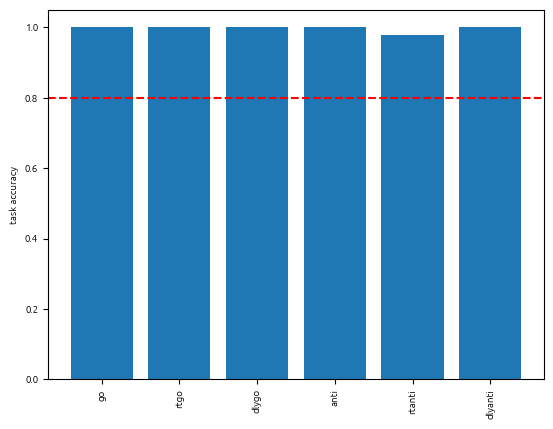

In [ ]:
### plot task accuracy
plt.figure()
plt.bar(envs_name,task_accuracy)
plt.xticks(rotation=90)
plt.ylabel('task accuracy')
plt.axhline(0.8,color='r',linestyle='--')
plt.show()

In [13]:
# we use kmean to compute cluster of RNN units
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(task_units_variance.T)
cluster_labels = kmeans.labels_
# permute units activity array to have them grouped by cluster
task_units_variance = task_units_variance[:,np.argsort(cluster_labels)]

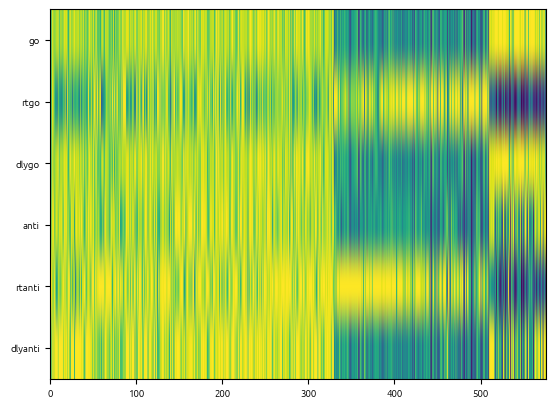

In [14]:
plt.figure()
plt.imshow(task_units_variance,aspect='auto')
plt.yticks(np.arange(len(envs_name)),envs_name)
plt.show()

/tmp/ipykernel_185867/726363049.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


[   0   19   39   59   79   99  119  139  159  179  199  219  239  259
  279  299  319  339  359  379  399  419  439  459  479  499  519  539
  559  579  599  619  639  659  679  699  719  739  759  779  799  819
  839  859  879  899  919  939  959  979 1000]


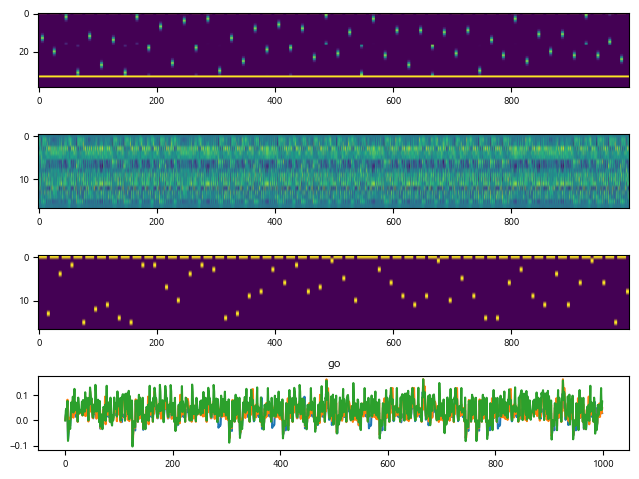

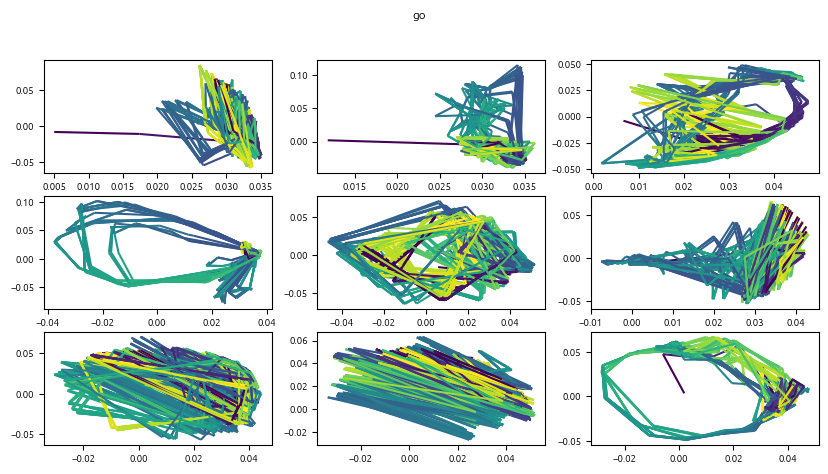

/tmp/ipykernel_185867/726363049.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


[   0    9   19   29   39   49   59   69   79   89   99  109  119  129
  139  149  159  169  179  189  199  209  219  229  239  249  259  269
  279  289  299  309  319  329  339  349  359  369  379  389  399  409
  419  429  439  449  459  469  479  489  499  509  519  529  539  549
  559  569  579  589  599  609  619  629  639  649  659  669  679  689
  699  709  719  729  739  749  759  769  779  789  799  809  819  829
  839  849  859  869  879  889  899  909  919  929  939  949  959  969
  979  989 1000]


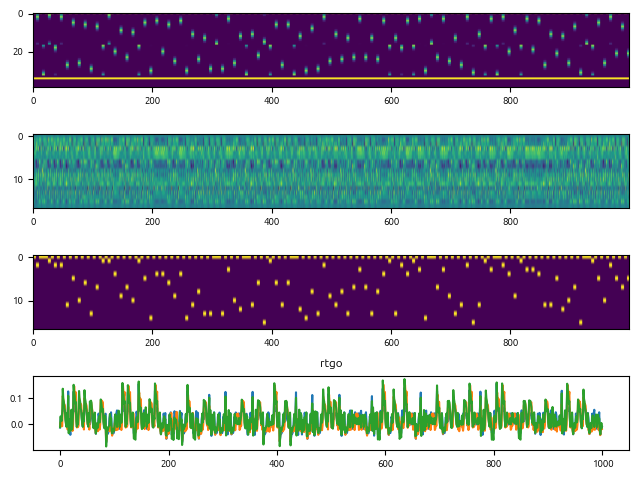

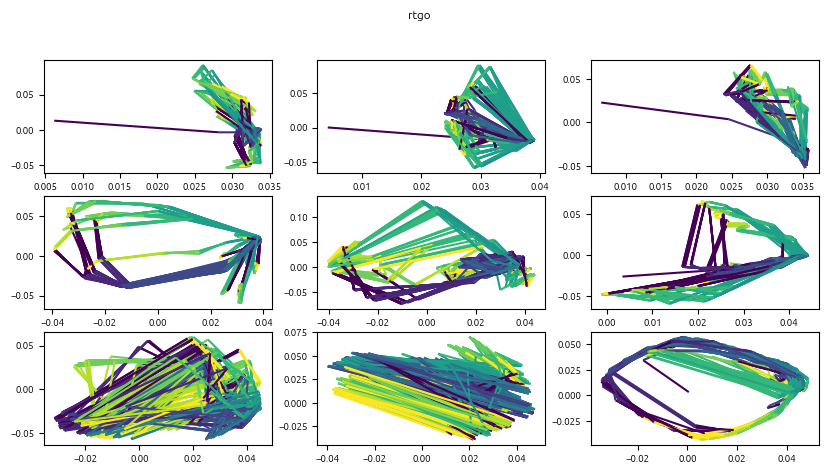

/tmp/ipykernel_185867/726363049.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


[   0   19   39   59   79   99  119  139  159  179  199  219  239  259
  279  299  319  339  359  379  399  419  439  459  479  499  519  539
  559  579  599  619  639  659  679  699  719  739  759  779  799  819
  839  859  879  899  919  939  959  979 1000]


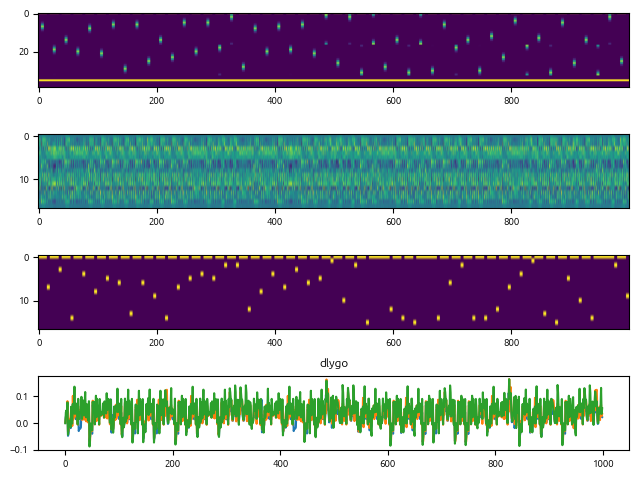

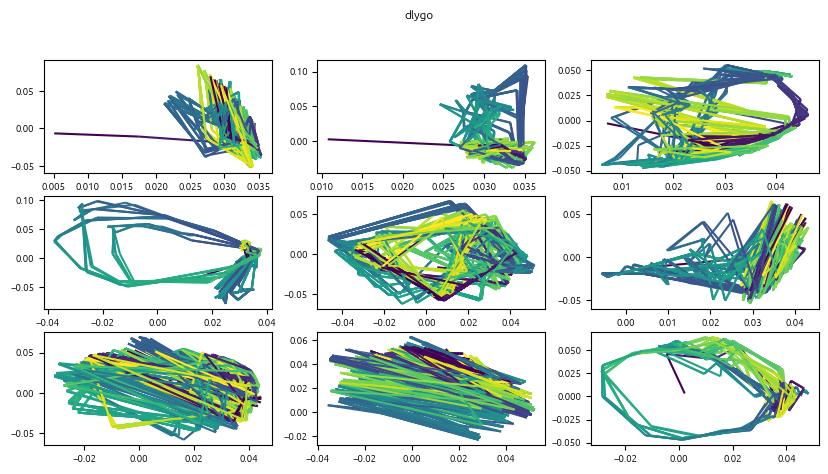

/tmp/ipykernel_185867/726363049.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


[   0   19   39   59   79   99  119  139  159  179  199  219  239  259
  279  299  319  339  359  379  399  419  439  459  479  499  519  539
  559  579  599  619  639  659  679  699  719  739  759  779  799  819
  839  859  879  899  919  939  959  979 1000]


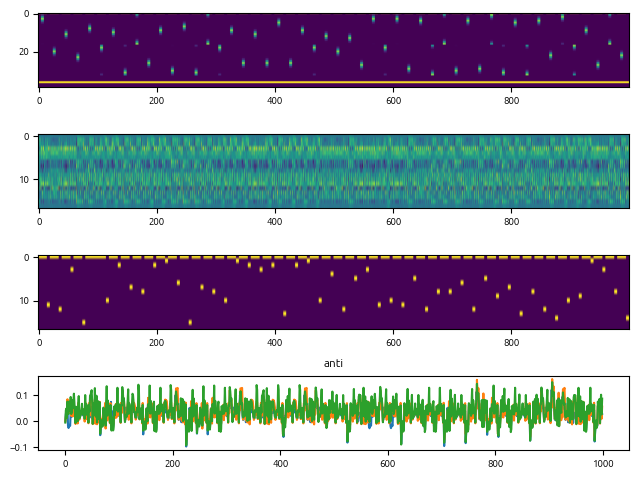

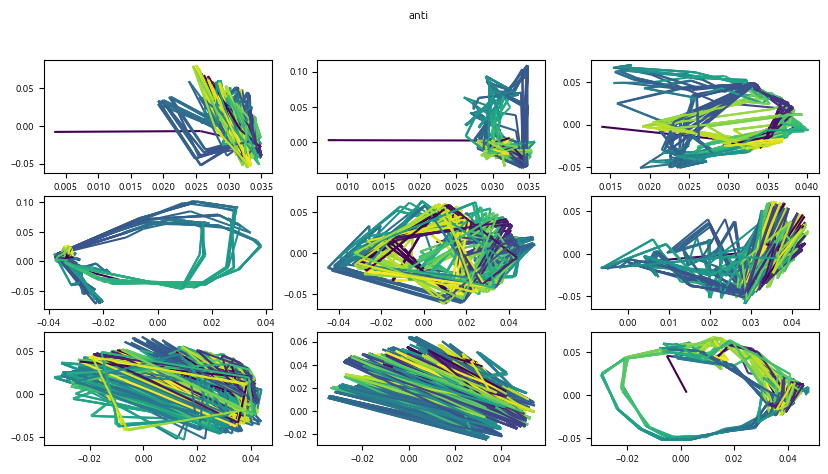

/tmp/ipykernel_185867/726363049.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


[   0    9   19   29   39   49   59   69   79   89   99  109  119  129
  139  149  159  169  179  189  199  209  219  229  239  249  259  269
  279  289  299  309  319  329  339  349  359  369  379  389  399  409
  419  429  439  449  459  469  479  489  499  509  519  529  539  549
  559  569  579  589  599  609  619  629  639  649  659  669  679  689
  699  709  719  729  739  749  759  769  779  789  799  809  819  829
  839  849  859  869  879  889  899  909  919  929  939  949  959  969
  979  989 1000]


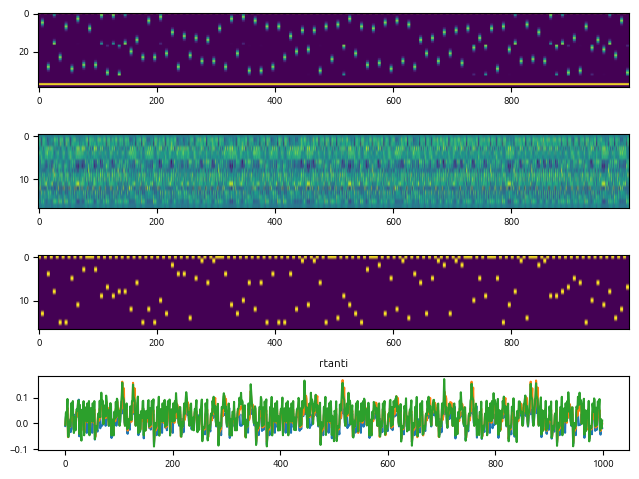

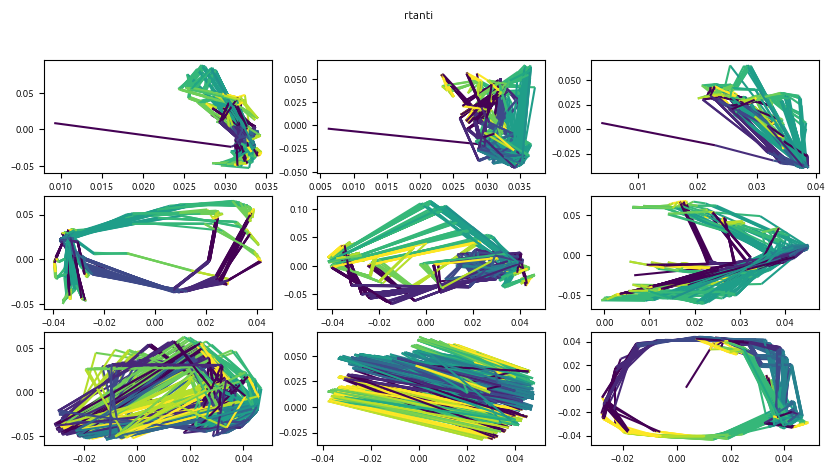

/tmp/ipykernel_185867/726363049.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


[   0   19   39   59   79   99  119  139  159  179  199  219  239  259
  279  299  319  339  359  379  399  419  439  459  479  499  519  539
  559  579  599  619  639  659  679  699  719  739  759  779  799  819
  839  859  879  899  919  939  959  979 1000]


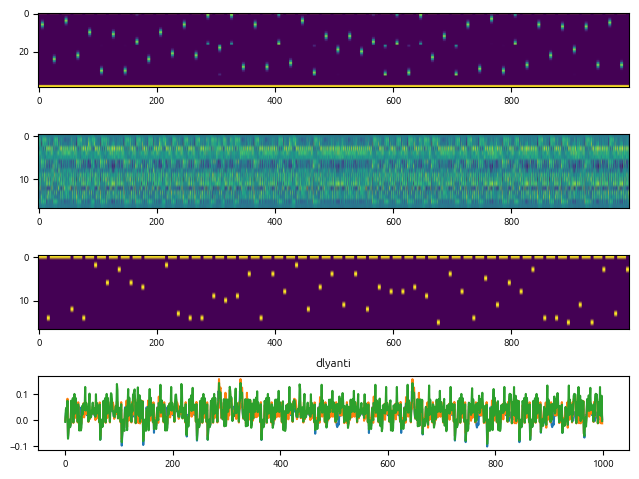

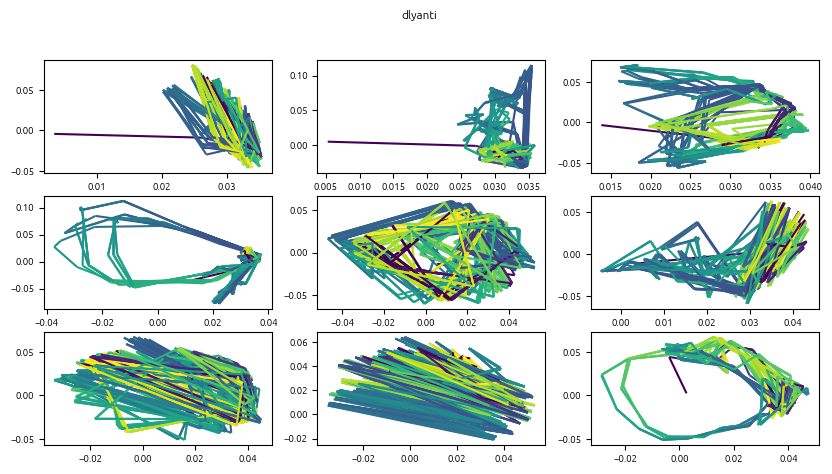

In [ ]:
from sklearn.decomposition import PCA
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti(),
                dm1(), dm2(), ctxdm1(), ctxdm2(), multidm(), dlydm1(), dlydm2(),
                ctxdlydm1(), ctxdlydm2(), multidlydm(), dms(), dnms(), dmc(), dnmc()]

envs_name = ['go', 'rtgo', 'dlygo', 'anti', 'rtanti', 'dlyanti',
                'dm1', 'dm2', 'ctxdm1', 'ctxdm2', 'multidm', 'dlydm1', 'dlydm2',
                'ctxdlydm1', 'ctxdlydm2', 'multidlydm', 'dms', 'dnms', 'dmc', 'dnmc']


envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti()]
envs_name = ['go', 'rtgo', 'dlygo', 'anti', 'rtanti', 'dlyanti']

batch_size = 1
seq_len = 1000

task_units_variance = []
task_accuracy = []

for i,env in enumerate(envs_simple) :
        



        # iterable dataset from which it is possible to draw samples
        dataset = Dataset(env, batch_size=batch_size, seq_len=seq_len)
        ob_size = env.observation_space.shape[0]
        act_size = env.action_space.n

        # we test for one trajectory
        inputs, labels = dataset()
        inputs = np.transpose(inputs, (1, 0, 2))
        labels = np.transpose(labels, (1, 0))
        targets = np.eye(act_size)[labels]
        
        # we need to add 20 dimensions to the input, corresponding to the task identity
        task_identity = np.zeros((inputs.shape[0],inputs.shape[1],len(envs_simple)))
        task_identity[:,:,i] = 1
        inputs = np.concatenate((inputs,task_identity),axis=2)
        
        outputs_total,hidden_states,attn_in, attn_com,_ = model(torch.tensor(inputs,dtype=torch.float).to(device))


        targets = np.eye(act_size)[labels]

        outputs = outputs_total.detach().cpu().numpy()
        attn_in = torch.stack(attn_in).detach().cpu().numpy()
        attn_com = attn_com.detach().cpu().numpy() # torch.stack(attn_com)
        attn_in = attn_in.reshape(seq_len,-1)
        attn_com = attn_com.reshape(seq_len,-1)

        f = plt.figure()
        plt.subplot(411)
        plt.imshow(inputs[:,:,:].T,aspect='auto')
        plt.subplot(412)
        plt.imshow((outputs[:,:,:].T),aspect='auto')
        plt.subplot(413)
        plt.imshow(targets[:,:,:].T,aspect='auto')
        plt.subplot(414)
        # plt.imshow(attn_com[:,:].T,aspect='auto')
        # plt.plot(attn_com[:,:])
        attn_com_len = attn_com.shape[1]
        plt.plot(np.mean(attn_com[:,:attn_com_len//3],axis=1))
        plt.plot(np.mean(attn_com[:,attn_com_len//3:2*attn_com_len//3],axis=1))
        plt.plot(np.mean(attn_com[:,2*attn_com_len//3:],axis=1))
        plt.title(envs_name[i])
        f.tight_layout()
        f.show()

        # we want to sequence the sequenc into trials by getting index of when the task changes
        task_changes = np.where(np.diff((inputs[0,:,0] > 0)*1) > 0)[0]
        # we add 0 and the last index to the task changes
        task_changes = np.concatenate(([0],task_changes,[len(inputs[0])]))
        print(task_changes)
        # Create color gradient for each trial
        trial_colors = []
        for i_trial in range(len(task_changes)-1):
            trial_length = task_changes[i_trial+1] - task_changes[i_trial]
            gradient = np.linspace(0, 1, trial_length)
            trial_colors.extend(gradient)

        # Choose a colormap (e.g., 'viridis', 'plasma', 'magma', 'inferno')
        cmap = plt.cm.viridis

        # Convert progression values to RGB colors
        colors = cmap(trial_colors)  # Returns RGBA values for each point


        hidden_states = np.squeeze(torch.stack(hidden_states).detach().cpu().numpy(),axis=1)
        # hidden_states = hidden_states.reshape(seq_len,-1)
        
        # for every module we would like to see the pca space of the hidden states
        f,axs = plt.subplots(3,3,figsize=(10,5))
        for i_mech in range(hidden_states.shape[1]) :
            hidden_states_mech = hidden_states[:,i_mech,:]
            hidden_states_mech = hidden_states_mech.T
            pca = PCA(n_components=2)
            pca.fit(hidden_states_mech)
            ax = axs[i_mech//3,i_mech%3]
            # ax.scatter(pca.components_[0,:],pca.components_[1,:],c=colors)
            points = np.column_stack((pca.components_[0,:], pca.components_[1,:]))
            segments = np.array([points[i:i+2] for i in range(len(points)-1)])
            lc = LineCollection(segments, cmap='viridis', array=trial_colors[:-1])
            ax.add_collection(lc)
            ax.autoscale()
        f.suptitle(envs_name[i])
        plt.show()